In [1]:
# try:
#     import os
#     from google.colab.drive import mount
#     mount('./drive')
#     %cd 'drive/My Drive/Colab Notebooks/Final Project'
#     if not os.path.exists('flower_data.zip'):
# #     !wget https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
#         !wget https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
#     if not os.path.exists('flower_data'):
# #     !unzip flower_data.zip
#         !mkdir flower_data
#         !tar -C ./flower_data -xvzf flower_data.tar.gz
# except ImportError:
#     pass
!nvidia-smi

Wed Jan  9 19:30:31 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 396.44                 Driver Version: 396.44                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           On   | 00003C97:00:00.0 Off |                    0 |
| N/A   43C    P0    55W / 149W |      0MiB / 11441MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# !pip3 uninstall -y Pillow
# !pip3 install Pillow==5.3.0
# !pip3 install http://download.pytorch.org/whl/cu80/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
# # !pip3 install https://download.pytorch.org/whl/cu80/torch-0.4.0-cp36-cp36m-linux_x86_64.whl
# !pip3 install torchvision
import PIL
print(PIL.PILLOW_VERSION)

5.3.0


In [3]:
# Imports here
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch import optim, nn
from torch.optim import lr_scheduler
import time
import os
import copy
import json
import time

In [4]:
# !pip install gdown==3.6.0
# # https://drive.google.com/open?id=1W26FgrVjl-HHG77XL--v4s1mgE0a0ju1
# my_file_id = '1W26FgrVjl-HHG77XL--v4s1mgE0a0ju1'
# !gdown https://drive.google.com/uc?id={my_file_id}
# !ls
# !unzip big_data.zip
from IPython.display import Audio, display

def allDone():
    display(Audio(url='https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav', autoplay=True))

In [5]:
data_dir = 'big_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# TODO: Define your transforms for the training and validation sets
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
batch_size = 32
data_transforms = {
    "train": transforms.Compose([
        transforms.RandomAffine(45, translate=(0.1,0.1), scale=(0.8,1.2), shear=10),
        transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    "valid": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    "test": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    "train": ImageFolder(train_dir, transform=data_transforms["train"]),
    "valid": ImageFolder(valid_dir, transform=data_transforms["valid"]),
    "test": ImageFolder(valid_dir, transform=data_transforms["test"])
}

# ratio = 0.25
# num = int(ratio*len(image_datasets["train"]))
# scale_down,_ = random_split(image_datasets["train"], [num, len(image_datasets["train"])-num])
# TODO: Using the image datasets and the trainforms, define the dataloaders

dataloaders = {
    "train": DataLoader(image_datasets["train"], batch_size=batch_size, shuffle=True),
    "valid": DataLoader(image_datasets["valid"], batch_size=batch_size, shuffle=True),
    "test": DataLoader(image_datasets["test"], batch_size=batch_size, shuffle=True),
}

# dataloaders = {
#     "train": DataLoader(scale_down, batch_size=batch_size, shuffle=True),
#     "valid": DataLoader(image_datasets["valid"], batch_size=batch_size, shuffle=True),
#     "test": DataLoader(image_datasets["test"], batch_size=batch_size, shuffle=True),
# }

In [7]:
# with open('cat_to_name.json', 'r') as f:
#     cat_to_name = json.load(f)
# sorted(cat_to_name)
cat_to_name = [0]*102

In [8]:
def plt_stats(stats_error, stats_accuracy):
    plt.figure(figsize=(15,5))
    plt.title('stats')
    plt.subplot(121)
    plt.plot(stats_error['train'],label="train")
    plt.plot(stats_error['valid'], label="validation")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.title("LOSS")
    plt.subplot(122)
    plt.plot(stats_accuracy['train'], label="train")
    plt.plot(stats_accuracy['valid'], label="validation")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.title("ACCURACY")
    plt.savefig(str(time.time())+'.jpg')

In [9]:
def train(epochs, model, optimizer, scheduler, dataloaders, criterion, model_name="my_model.pt", save=True, best_acc=0.0, stats_error = {'train':[], 'valid': []}, stats_accuracy = {'train':[], 'valid': []}):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch+1, epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            print(phase, end='')
            if phase == 'train':
                if str(type(scheduler)) != "<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>":
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                print('.', end='')
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data).item()
            print()
            
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)
            stats_error[phase].append(epoch_loss)
            stats_accuracy[phase].append(epoch_acc)
            
            if phase=="valid" and str(type(scheduler)) == "<class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>":
                scheduler.step(metrics = epoch_loss)
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

        # deep copy the model
            if phase == 'valid' and epoch_acc >= best_acc:
                print("accuracy increased from {:.4f} to {:.4f}, saving model....".format(best_acc, epoch_acc))
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                if save:
                    torch.save(model.state_dict(), model_name)
        print()
    
    json.dump({"stats_error":stats_error, "stats_accuracy": stats_accuracy}, open('stats-'+str(time.time())+'.json', 'w'))
    plt_stats(stats_error, stats_accuracy)
    model.load_state_dict(best_model_wts)
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    allDone()
    
    return best_acc, model


In [10]:
def test(model, dataloaders):
    model.eval()
    running_corrects = 0.0
    for batch, (inputs, labels) in enumerate(dataloaders['test']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        # statistics
        accu =  torch.sum(preds == labels.data)
        running_corrects += accu.data.item()
        print("batch:", batch+1, "Accuracy:", accu.data.item()/len(inputs))
    print("overall accuracy:", running_corrects/len(dataloaders['test'].dataset))

In [11]:
def google_test(model):
    !git clone https://github.com/GabrielePicco/deep-learning-flower-identifier
    !pip install airtable
    import sys
    sys.path.insert(0, 'deep-learning-flower-identifier')
    
    import PIL
    print(PIL.PILLOW_VERSION)

    # model = model.to(device)
    model.eval()
    from test_model_pytorch_facebook_challenge import calc_accuracy
    calc_accuracy(model, input_image_size=224, use_google_testset=True, batch_size=batch_size, norm_mean = mean, norm_std=std)

In [12]:
# TODO: Build and train your network
model = torchvision.models.resnet152(pretrained=True)

length = len(list(model.parameters()))

for idx,param in enumerate(model.parameters()):
    if idx < length-10:
        param.requires_grad = False

in_features = model.fc.in_features
# in_features = model.classifier[0].in_features
out_features = len(cat_to_name)

fc = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(512, out_features)
)


model.fc = fc

model = model.to(device)

In [15]:
epochs = 20
lr = 1e-1
gamma = 0.1
step_size = 5
momentum = 0.8
cooldown = 1
best_acc = 0.5876
model.load_state_dict(torch.load('goog_prev1.pt'))
optimizer = optim.SGD(model.parameters(), lr=lr, momentum = momentum)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=step_size, cooldown=cooldown,verbose=True)

Epoch 1/20
----------
train............................................................................................................................................................................................................................................................................................
train Loss: 2.0688 Acc: 0.4725
valid.......................................................
valid Loss: 1.3147 Acc: 0.6443
accuracy increased from 0.5876 to 0.6443, saving model....

Epoch 2/20
----------
train............................................................................................................................................................................................................................................................................................
train Loss: 1.7997 Acc: 0.5353
valid.......................................................
valid Loss: 0.9395 Acc: 0.7426
accuracy increased from 0.6443 to 0.7426, saving model....

Epoch 3/20

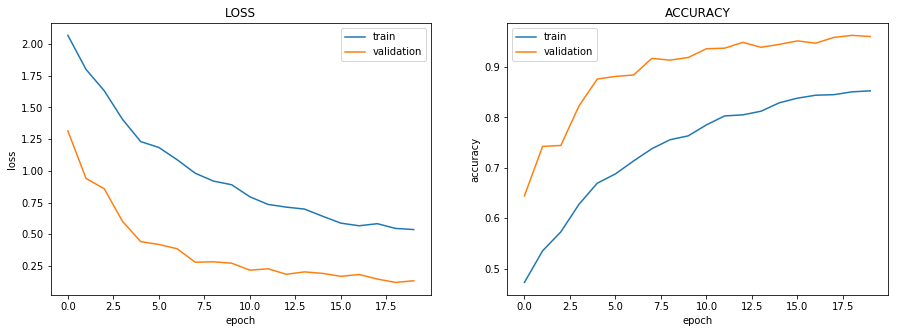

In [17]:
best_acc, model = train(epochs, model, optimizer, scheduler, dataloaders, criterion, model_name="goog_prev1.pt", best_acc = best_acc)

In [18]:
test(model, dataloaders)

batch: 1 Accuracy: 0.96875
batch: 2 Accuracy: 0.9375
batch: 3 Accuracy: 0.9375
batch: 4 Accuracy: 0.96875
batch: 5 Accuracy: 0.96875
batch: 6 Accuracy: 0.9375
batch: 7 Accuracy: 1.0
batch: 8 Accuracy: 1.0
batch: 9 Accuracy: 0.9375
batch: 10 Accuracy: 1.0
batch: 11 Accuracy: 0.9375
batch: 12 Accuracy: 0.96875
batch: 13 Accuracy: 0.96875
batch: 14 Accuracy: 0.96875
batch: 15 Accuracy: 0.96875
batch: 16 Accuracy: 0.9375
batch: 17 Accuracy: 0.90625
batch: 18 Accuracy: 0.9375
batch: 19 Accuracy: 0.9375
batch: 20 Accuracy: 1.0
batch: 21 Accuracy: 0.96875
batch: 22 Accuracy: 1.0
batch: 23 Accuracy: 1.0
batch: 24 Accuracy: 0.9375
batch: 25 Accuracy: 0.96875
batch: 26 Accuracy: 0.9375
batch: 27 Accuracy: 1.0
batch: 28 Accuracy: 0.9375
batch: 29 Accuracy: 1.0
batch: 30 Accuracy: 0.96875
batch: 31 Accuracy: 0.9375
batch: 32 Accuracy: 0.96875
batch: 33 Accuracy: 0.9375
batch: 34 Accuracy: 0.96875
batch: 35 Accuracy: 0.9375
batch: 36 Accuracy: 1.0
batch: 37 Accuracy: 1.0
batch: 38 Accuracy: 0.9375


In [19]:
google_test(model)

fatal: destination path 'deep-learning-flower-identifier' already exists and is not an empty directory.
5.3.0
Batch accuracy (Size 32): 0.8125
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.8125
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.78125
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.8125
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.90625
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.875
Batch accuracy (Size 32): 0.9375
Batch accuracy (Size 32): 0.8125
B

In [19]:
best_acc = 0.9960
model.load_state_dict(torch.load('goog1.pt'))
for idx,param in enumerate(model.parameters()):
    if idx > 15:
        param.requires_grad = True

epochs = 20
lr = 1e-4
gamma = 0.1
step_size = 5
momentum = 0.8
cooldown = 1


optimizer = optim.SGD(model.parameters(), lr=lr, momentum = momentum)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=step_size, cooldown=cooldown, verbose=True)

In [20]:
best_acc, model = train(epochs, model, optimizer, scheduler, dataloaders, criterion, model_name="goog1.pt", best_acc=best_acc)

Epoch 1/20
----------
train............................................................................................................................................................................................................................................................................................
train Loss: 0.2389 Acc: 0.9350
valid.......................................................
valid Loss: 0.0181 Acc: 0.9948

Epoch 2/20
----------
train....................

KeyboardInterrupt: 

In [16]:
test(model, dataloaders)

batch: 1 Accuracy: 1.0
batch: 2 Accuracy: 1.0
batch: 3 Accuracy: 1.0
batch: 4 Accuracy: 1.0
batch: 5 Accuracy: 0.96875
batch: 6 Accuracy: 1.0
batch: 7 Accuracy: 1.0
batch: 8 Accuracy: 1.0
batch: 9 Accuracy: 1.0
batch: 10 Accuracy: 1.0
batch: 11 Accuracy: 1.0
batch: 12 Accuracy: 1.0
batch: 13 Accuracy: 1.0
batch: 14 Accuracy: 0.96875
batch: 15 Accuracy: 1.0
batch: 16 Accuracy: 1.0
batch: 17 Accuracy: 1.0
batch: 18 Accuracy: 1.0
batch: 19 Accuracy: 1.0
batch: 20 Accuracy: 1.0
batch: 21 Accuracy: 1.0
batch: 22 Accuracy: 1.0
batch: 23 Accuracy: 1.0
batch: 24 Accuracy: 1.0
batch: 25 Accuracy: 1.0
batch: 26 Accuracy: 1.0
batch: 27 Accuracy: 1.0
batch: 28 Accuracy: 1.0
batch: 29 Accuracy: 1.0
batch: 30 Accuracy: 1.0
batch: 31 Accuracy: 1.0
batch: 32 Accuracy: 1.0
batch: 33 Accuracy: 1.0
batch: 34 Accuracy: 1.0
batch: 35 Accuracy: 1.0
batch: 36 Accuracy: 0.96875
batch: 37 Accuracy: 1.0
batch: 38 Accuracy: 1.0
batch: 39 Accuracy: 0.96875
batch: 40 Accuracy: 1.0
batch: 41 Accuracy: 1.0
batch: 42

In [17]:
google_test(model)

fatal: destination path 'deep-learning-flower-identifier' already exists and is not an empty directory.
5.3.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 0.96875
Batch accuracy (Size 32): 1.0
Batch accuracy (Size 32): 1.0
Batc

In [13]:
# best_acc = 0.9977
model.load_state_dict(torch.load('goog1.pt'))

for idx,param in enumerate(model.parameters()):
    param.requires_grad = True

epochs = 20
lr = 1e-12
gamma = 0.1
step_size = 5
momentum = 0.8
cooldown = 1

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=step_size, cooldown=cooldown, verbose=True)

In [ ]:
best_acc,model = train(epochs, model, optimizer, scheduler, dataloaders, criterion, model_name="goog_final1.pt",best_acc=best_acc)

Epoch 1/20
----------
train............................................................................................................................................................................................................................................................................................
train Loss: 0.0750 Acc: 0.9805
valid.......................................................
valid Loss: 0.0091 Acc: 0.9971

Epoch 2/20
----------
train............................................................................................................................................................................................................................................................................................
train Loss: 0.0743 Acc: 0.9792
valid.......................................................
valid Loss: 0.0098 Acc: 0.9971

Epoch 3/20
----------
train.....................................................................................................

In [ ]:
test(model, dataloaders)

In [ ]:
google_test(model)

AttributeError: 'ResNet' object has no attribute 'device'